In [3]:
%cd ../data/external
!if [ ! -e "CubiCasa5k" ]; then git clone "https://github.com/CubiCasa/CubiCasa5k.git"; fi
%cd CubiCasa5k

!pip install lmdb
!pip install svgpathtools

/home/xfaron/Desktop/Code/Playground/test_construction/data/external
/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k


In [4]:
import os
import sys

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms.v2 import functional as F
from torchvision.ops.boxes import masks_to_boxes, box_area
from floortrans.loaders.house import House
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import random

In [5]:
class FloorplanSVG(Dataset):
    def __init__(self, data_folder, data_file):
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )  # Image normalization
        self.apply_transform = True
        self.image_file_name = "/F1_scaled.png"
        self.org_image_file_name = "/F1_original.png"
        self.svg_file_name = "/model.svg"

        self.data_folder = data_folder
        # Loading txt file
        text_file_path = os.path.join(data_folder, data_file)
        self.folders = np.genfromtxt(text_file_path, dtype="str")

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, index):
        image, target = self.get_data(index)

        if self.apply_transform:
            image = self.transform(image)
        return image, target

    def get_data(self, index):
        fplan = cv2.imread(
            self.data_folder + self.folders[index] + self.image_file_name
        )
        fplan = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)  # correct color channels
        height, width, _ = fplan.shape

        house = House(
            self.data_folder + self.folders[index] + self.svg_file_name, height, width
        )

        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)

        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(
            dtype=torch.uint8
        )
        boxes = masks_to_boxes(masks)  # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)
        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]

        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        for i in range(len(final_masks)):
            rows, cols = np.where(final_masks[i])
            labels[i] = wall_labels[rows[0], cols[0]]

        target = {}
        target["masks"] = final_masks
        target["boxes"] = final_boxes
        target["labels"] = labels

        return fplan, target

In [6]:
def load_data_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    image, target = dataset[index]
    return image, target


def visualize_data_sample(image, target, mask_index=None, combine_masks=False):
    image_np = image.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    masks = target["masks"].cpu().numpy()
    print(masks.shape)

    if combine_masks:
        combined_mask = np.sum(masks, axis=0)
        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap="gray")
        plt.title("Combined Mask")
        plt.axis("off")
    else:
        if mask_index is None:
            mask_index = 0
        if mask_index < len(masks):
            plt.subplot(1, 2, 2)
            plt.imshow(masks[mask_index], cmap="gray")
            plt.title(f"Mask {mask_index}")
            plt.axis("off")
        else:
            print(
                f"Mask index {mask_index} is out of range. There are {len(masks)} masks."
            )

    plt.show()


def visualize_data_sample_boxes(image, target, mask_index=None, combine_masks=False):
    image_np = image.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")
    plt.axis("off")

    masks = target["boxes"].cpu().numpy()
    print(masks.shape)

    if combine_masks:
        combined_mask = np.sum(masks, axis=0)
        plt.subplot(1, 2, 2)
        plt.imshow(combined_mask, cmap="gray")
        plt.title("Combined Boxes")
        plt.axis("off")
    else:
        if mask_index is None:
            mask_index = 0
        if mask_index < len(masks):
            plt.subplot(1, 2, 2)
            plt.imshow(masks[mask_index], cmap="gray")
            plt.title(f"Mask {mask_index}")
            plt.axis("off")
        else:
            print(
                f"Box index {mask_index} is out of range. There are {len(masks)} masks."
            )

    plt.show()

In [7]:
room_classes = [
    "Background",
    "Outdoor",
    "Wall",
    "Kitchen",
    "Living Room",
    "Bed Room",
    "Bath",
    "Entry",
    "Railing",
    "Storage",
    "Garage",
    "Undefined",
]
data_folder = "./data/cubicasa5k"

## Look Into Cubicasa5k

In [8]:
path = "./data/cubicasa5k/high_quality/20059"
test = House(path + "/model.svg", 1280, 1600)

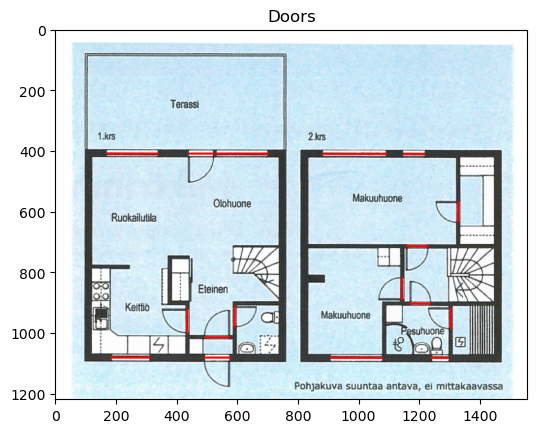

In [9]:
doors = test.representation["doors"]
img = cv2.imread(path + "/F1_scaled.png")

for i in range(len(doors)):
    pt1 = tuple(doors[i][0][0])
    pt2 = tuple(doors[i][0][1])

    # pt1 = (1.02, 2.04)
    # pt1 = (1, 2)

    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])

    img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 5)

plt.title("Doors")
plt.imshow(img)
plt.show()

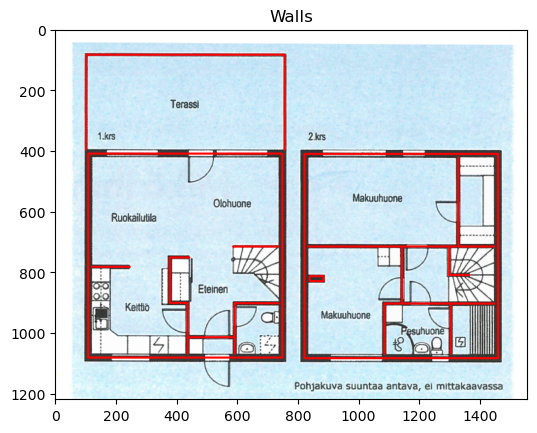

In [18]:
walls = test.representation["walls"]
img = cv2.imread(path + "/F1_scaled.png")

for i in range(len(walls)):
    pt1 = tuple(walls[i][0][0])
    pt2 = tuple(walls[i][0][1])

    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])

    img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 5)

plt.title("Walls")
plt.imshow(img)
plt.show()

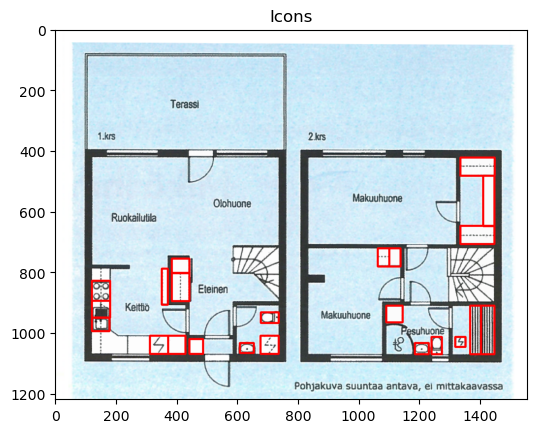

In [19]:
icon_corners = test.icon_corners
img = cv2.imread(path + "/F1_scaled.png")

for i in range(len(icon_corners["lower_left"])):
    pt1 = tuple(icon_corners["upper_left"][i])
    pt2 = tuple(icon_corners["lower_right"][i])

    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])

    img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 5)

plt.title("Icons")
plt.imshow(img)
plt.show()

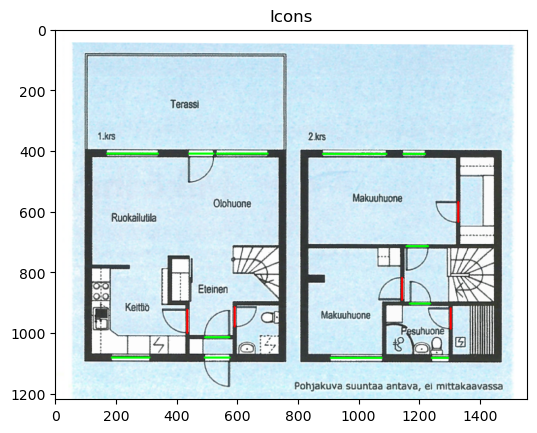

In [20]:
icon_corners = test.opening_corners
img = cv2.imread(path + "/F1_scaled.png")

for i in range(len(icon_corners["up"])):
    pt1 = tuple(icon_corners["up"][i])
    pt2 = tuple(icon_corners["down"][i])

    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])

    img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 5)

for i in range(len(icon_corners["left"])):
    pt1 = tuple(icon_corners["left"][i])
    pt2 = tuple(icon_corners["right"][i])

    pt1 = int(pt1[0]), int(pt1[1])
    pt2 = int(pt2[0]), int(pt2[1])

    img = cv2.rectangle(img, pt1, pt2, (0, 255, 0), 5)

plt.title("Icons")
plt.imshow(img)
plt.show()

In [15]:
data_file = "train.txt"

dataset = FloorplanSVG(data_folder, data_file)

image, target = load_data_sample(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(17, 1226, 1054)


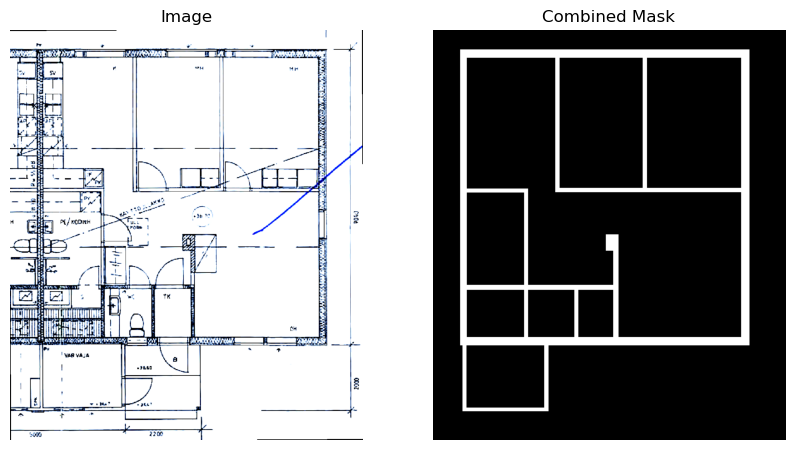

In [24]:
visualize_data_sample(image, target, combine_masks=True)

In [ ]:
data_file = "train.txt"

dataset = FloorplanSVG(data_folder, data_file)
image, target = load_data_sample(dataset)

masks = target["masks"]
boxes = target["boxes"]
labels = target["labels"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


Masks len:  38
Boxes len:  38
Labels len:  38
INDEX :  12

Shape of img:  torch.Size([3, 961, 1281])
Shape of mask:  torch.Size([961, 1281])
Mask 12:  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
Box 12:  [262  43 282  59]
Labels 12:  Wall
Unique labels:  {'Wall', 'Railing'}


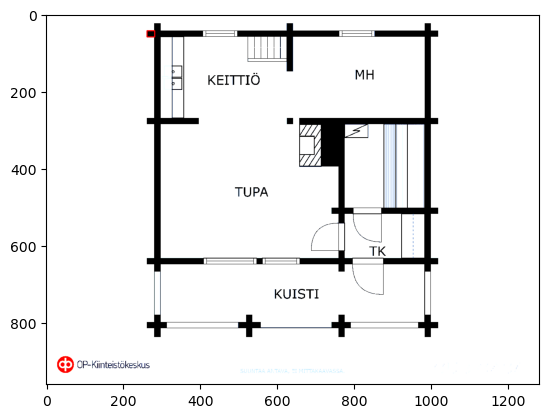

In [ ]:
print("Masks len: ", len(masks))
print("Boxes len: ", len(boxes))
print("Labels len: ", len(labels))

index = random.randint(0, len(boxes) - 1)
# index = 8 (Not proper boundary?),
print("INDEX : ", index)
print()

box = boxes[index].numpy().astype(int)

print("Shape of img: ", image.shape)
print("Shape of mask: ", masks[index].shape)

print(f"Mask {index}: ", masks[index])
print(f"Box {index}: ", box)
print(f"Labels {index}: ", room_classes[labels[index]])
print("Unique labels: ", set(map(lambda x: room_classes[x], labels)))

image_new = image.permute(1, 2, 0).cpu().numpy().copy()
cv2.rectangle(image_new, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.imshow(image_new)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


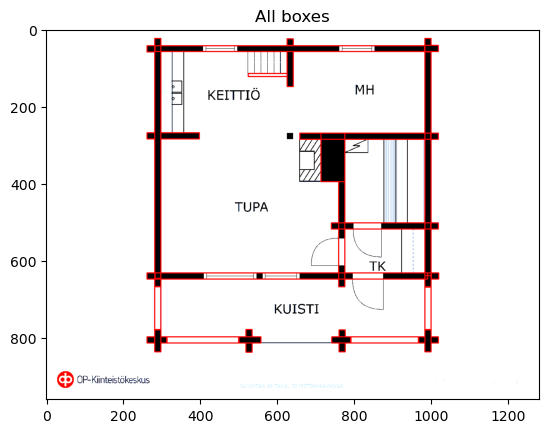

In [ ]:
image_full_boxes = image.permute(1, 2, 0).cpu().numpy().copy()
for i, box in enumerate(boxes):
    # if labels[i] != 2: continue

    box = box.numpy().astype(int)
    image_full_boxes = cv2.rectangle(
        image_full_boxes, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2
    )
plt.imshow(image_full_boxes)
plt.title("All boxes")
plt.show()

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch


def _to_numpy_img(image):

    if isinstance(image, torch.Tensor):
        img = image.detach().cpu()
        if img.ndim == 3 and img.shape[0] in (1, 3):  # CHW -> HWC
            img = img.permute(1, 2, 0)
        img = img.numpy()
    else:
        img = np.array(image)

    return img


def draw_boxes(img, boxes, color=(255, 0, 0), thickness=5):

    img_np = _to_numpy_img(img).copy()
    # convert RGB to BGR for OpenCV
    bgr = tuple(int(c) for c in color[::-1])

    if isinstance(boxes, torch.Tensor):
        boxes_np = boxes.detach().cpu().numpy()
    else:
        boxes_np = np.asarray(boxes)

    if boxes_np.size == 0:
        return img_np

    boxes_np = boxes_np.astype(int)
    if boxes_np.ndim == 1:
        boxes_np = boxes_np.reshape(1, 4)

    for box in boxes_np:
        x1, y1, x2, y2 = box
        cv2.rectangle(img_np, (int(x1), int(y1)), (int(x2), int(y2)), bgr, thickness)

    return img_np


def see_img_info(image, target=None, show_all_boxes=True):

    img_np = _to_numpy_img(image)

    if target is None:
        plt.imshow(img_np)
        plt.axis("off")
        plt.show()
        return

    # masks
    if "masks" in target:
        masks = target["masks"]
        try:
            print("Masks len:", len(masks))
            if len(masks) > 0:
                m0 = masks[0]
                if isinstance(m0, torch.Tensor):
                    m0 = m0.cpu().numpy()
                print(
                    "Mask[0] shape, dtype:",
                    getattr(m0, "shape", None),
                    getattr(m0, "dtype", None),
                )
        except Exception:
            print("Masks: could not inspect")

    # boxes
    if "boxes" in target:
        boxes = target["boxes"]
        try:
            print("Boxes len:", len(boxes))
            if len(boxes) > 0:
                b0 = boxes[0]
                if isinstance(b0, torch.Tensor):
                    b0 = b0.cpu().numpy()
                print("Box[0]:", np.array(b0).astype(int))
        except Exception:
            print("Boxes: could not inspect")

    # labels
    if "labels" in target:
        labels = target["labels"]
        try:
            labs = labels
            if isinstance(labels, torch.Tensor):
                labs = labels.cpu().numpy()
            print("Labels len:", len(labs))
            print("Unique labels:", np.unique(labs))
        except Exception:
            print("Labels: could not inspect")

    # show image (with boxes if requested)
    if show_all_boxes and "boxes" in target:
        img_with = draw_boxes(img_np, target["boxes"])
        plt.imshow(img_with)
        plt.title("All boxes")
        plt.axis("off")
        plt.show()
    else:
        plt.imshow(img_np)
        plt.axis("off")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


Masks len: 38
Mask[0] shape, dtype: (961, 1281) uint8
Boxes len: 38
Box[0]: [282  24 298 647]
Labels len: 38
Unique labels: [2 8]


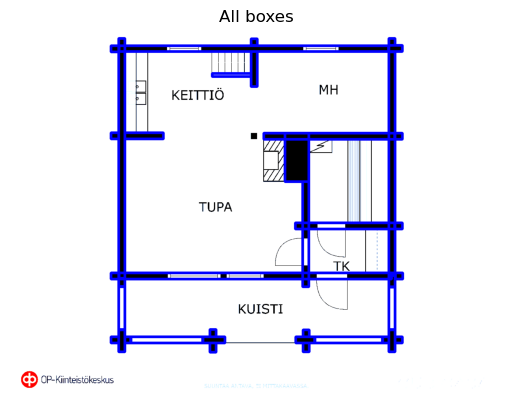

In [23]:
see_img_info(image, target, True)

# Preprocessing

In [ ]:
train_file = "train.txt"
val_file = "val.txt"

train_dataset = FloorplanSVG(data_folder, train_file)
val_dataset = FloorplanSVG(data_folder, val_file)

img_train = "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/roi/images/train"
img_val = "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/roi/images/val"
label_train = "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/roi/labels/train"
label_val = "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/roi/labels/val"

In [ ]:
def __are_groupable_boxes(box1, box2, padding):
    coords = [
        (box1[0], box1[1]),
        (box1[2], box1[3]),
        (box1[0], box1[3]),
        (box1[2], box1[1]),
    ]
    for coord in coords:
        x, y = coord
        if (x <= box2[2] + padding[0] and x >= box2[0] - padding[0]) and (
            y <= box2[3] + padding[1] and y >= box2[1] - padding[1]
        ):
            return True


def are_groupable_boxes(box1, box2, padding=(10, 10)):
    result = __are_groupable_boxes(box1, box2, padding)
    return result or __are_groupable_boxes(box2, box1, padding)


def group_boxes(box1, box2):
    return [
        min(box1[0], box2[0]),
        min(box1[1], box2[1]),
        max(box1[2], box2[2]),
        max(box1[3], box2[3]),
    ]


# TODO: Right now, this function does not do anything. Future
def include_doors(boundary_boxes, doors):
    return boundary_boxes


def generate_dir_structure(dataset, img_folder, label_folder):
    # Make required folders
    req_folders = [img_folder, label_folder]
    for folder in req_folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    for i, target in enumerate(dataset):
        image = image.permute(1, 2, 0).numpy().copy()

        target_boxes = target["boxes"].cpu().numpy().astype("int")
        boundary_boxes = []

        last_len = 0
        while True:
            for box in target_boxes:
                for j, boundary_box in enumerate(boundary_boxes):
                    if are_groupable_boxes(boundary_box, box):
                        boundary_boxes[j] = group_boxes(boundary_box, box)
                        break
                else:
                    boundary_boxes.append(box)
            target_boxes = boundary_boxes
            if last_len == len(boundary_boxes):
                break

            last_len = len(target_boxes)
            boundary_boxes = []

        # TODO
        boundary_boxes_with_doors = include_doors(boundary_boxes, [])

        with open(label_folder + "{i:4.0d}.txt") as f:
            for box in boundary_boxes_with_doors:
                x_center = (box[0] + box[2]) / 2
                y_center = (box[1] + box[3]) / 2
                width = box[2] - box[0]
                height = box[3] - box[1]

                f.write(f"0 {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}\n")

        os.system(f"cp {target["meta"]["path"]} {img_folder + "/{i:4.0d}.png"}")

In [ ]:
class SimpleSVGLoader(Dataset):
    def __init__(self, data_folder, data_file):
        self.image_file_name = "/F1_scaled.png"
        self.org_image_file_name = "/F1_original.png"
        self.svg_file_name = "/model.svg"

        self.data_folder = data_folder
        # Loading txt file
        text_file_path = os.path.join(data_folder, data_file)
        self.folders = np.genfromtxt(text_file_path, dtype="str")

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, index):
        target = self.get_data(index)
        return target

    def get_data(self, index):
        with Image.open(self.data_folder + self.folders[index] + self.image_file_name) as img:
            width, height = img.size

        house = House(
            self.data_folder + self.folders[index] + self.svg_file_name, height, width
        )

        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)
        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(
            dtype=torch.uint8
        )
        boxes = masks_to_boxes(masks)  # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)
        final_boxes = boxes[non_empty_indices]

        target = {}
        target["boxes"] = final_boxes
        target["meta"] = {
            "path": self.data_folder + self.folders[index] + self.image_file_name,
            "height" : height,
            "width" : width
        }

        return target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


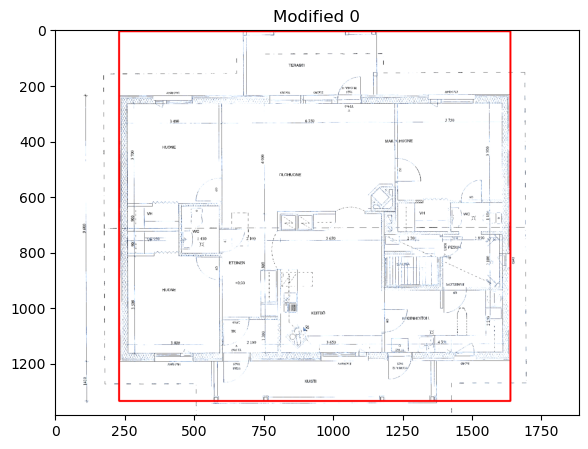

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..255.0].


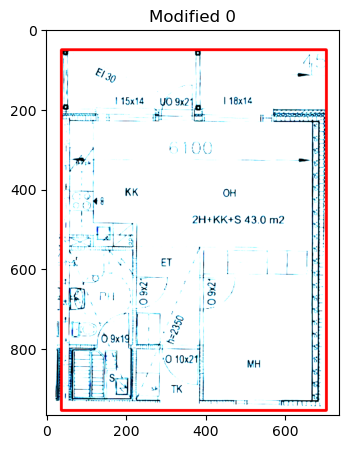

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..255.0].


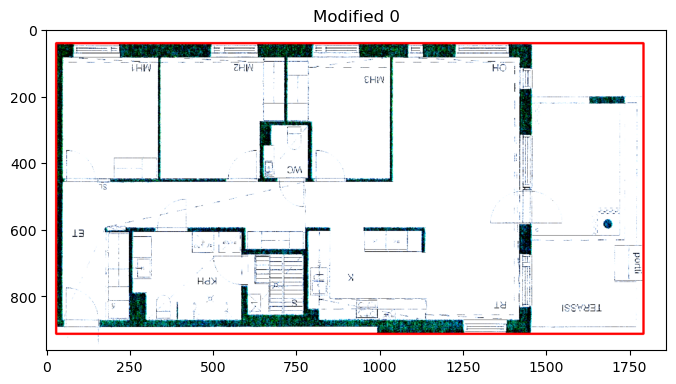

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


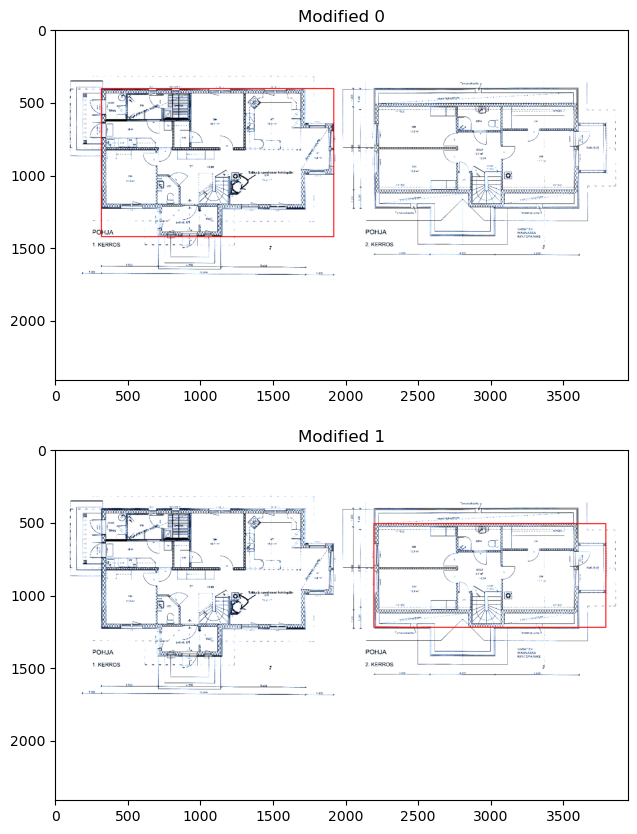

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


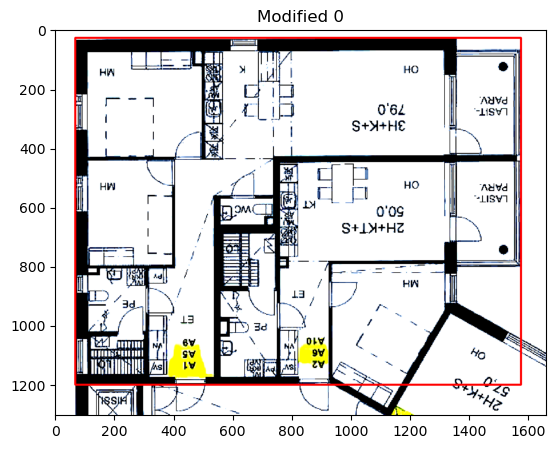

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


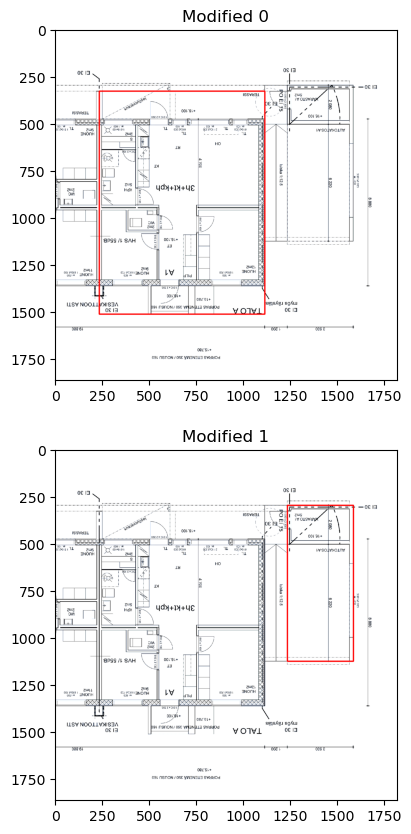

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..255.0].


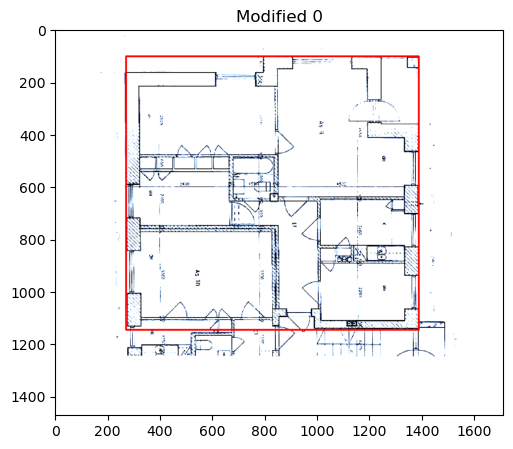

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


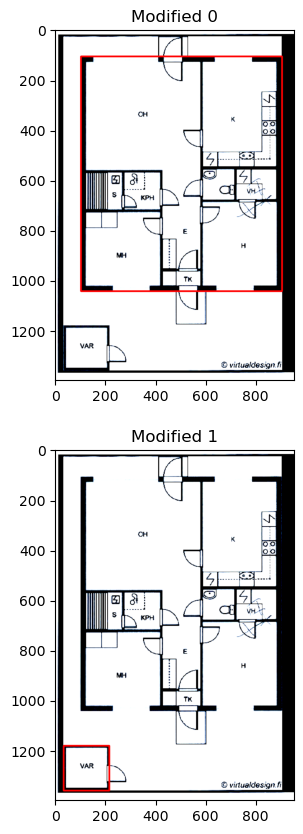

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


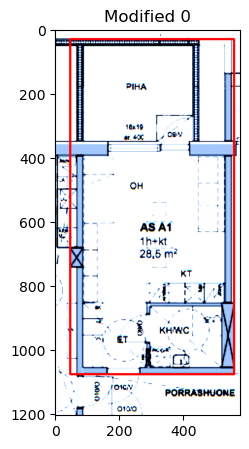

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


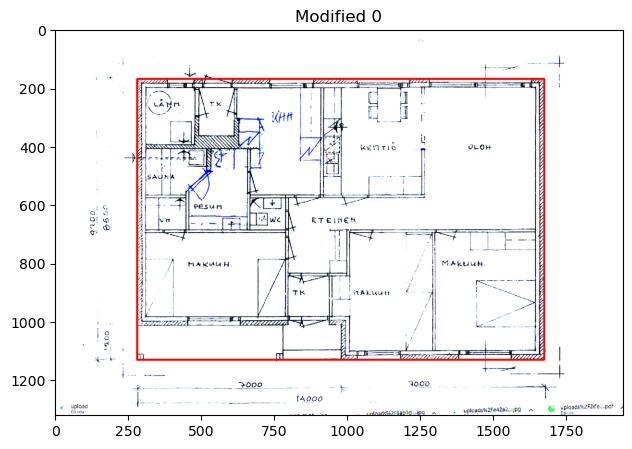

In [31]:
for i in range(10):
    image, target = load_data_sample(train_dataset)
    image = image.permute(1, 2, 0).numpy().copy()

    target_boxes = target["boxes"].cpu().numpy().astype("int")
    boundary_boxes = []

    last_len = 0
    while True:
        for box in target_boxes:
            for j, boundary_box in enumerate(boundary_boxes):
                if are_groupable_boxes(boundary_box, box):
                    boundary_boxes[j] = group_boxes(boundary_box, box)
                    break
            else:
                boundary_boxes.append(box)
        target_boxes = boundary_boxes
        if last_len == len(boundary_boxes):
            break

        last_len = len(target_boxes)
        boundary_boxes = []
    boundary_boxes = include_doors(boundary_boxes, [])

    fig, axs = plt.subplots(
        ncols=1, nrows=len(target_boxes), figsize=(8, 5 * len(target_boxes))
    )
    axs = np.atleast_1d(axs)

    for i, box in enumerate(target_boxes):
        x1, y1, x2, y2 = box
        image_boxes = image.copy()
        image_boxes = cv2.rectangle(
            image_boxes, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 5
        )

        axs[i].set_title(f"Modified {i}")
        axs[i].imshow(image_boxes)

    plt.show()